# Goals of this notebook:  
### 1. colormaps at either end of SNR  
### 2. plot of cumulative information versus SNR for various models (full, horz, ama, ideal)

In [1]:
import numpy as np
from scipy.stats import sem

# import my functions
# import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.stats import sem
from scipy.interpolate import interp1d


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = np.mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Signal

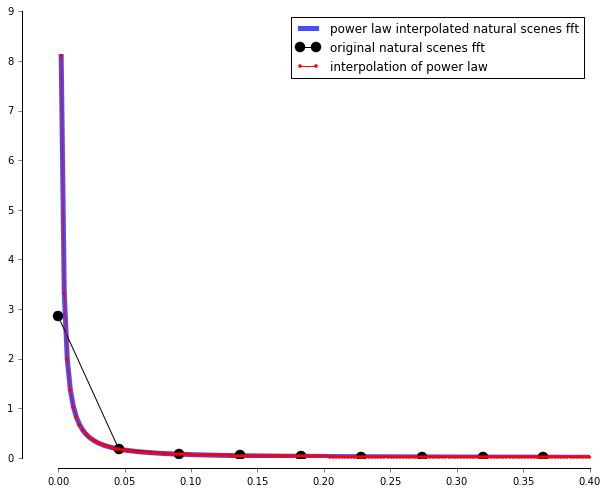

In [4]:
# interpolate signal amplitude
# power law
npoints = 10000
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
more_signal_freq   = np.linspace(0., originalFreqs[-1], npoints)[1:]
more_signal_amp = func(more_signal_freq, *popt)
signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

plt.plot(more_signal_freq, more_signal_amp, 'b', linewidth=5, alpha=0.7, label='power law interpolated natural scenes fft')
plt.plot(originalFreqs, originalSpectra, 'k.-', markersize=20, label='original natural scenes fft')
plt.plot(more_signal_freq, signal_interp(more_signal_freq), 'r.-', linewidth=1, label='interpolation of power law')
plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# Define range of input and output noises we're considering  
Here I'm using the same noises used for the figure with multiple SNRs

In [5]:
noises = [(0.05, 0.1), (0.12, 0.35), (0.08, 0.2), (0.2, 0.42)]

## Define information at a given frequency

In [6]:
def info_at_freq(freqs, signal_amplitude, filter_interpolation_function, function_const=1., input_noise=0.12, output_noise=0.35):
    numerator = (signal_amplitude * function_const * filter_interpolation_function(freqs))**2
    denominator = ((input_noise * function_const * filter_interpolation_function(freqs))**2 + output_noise**2)
    return 0.5*np.log2(1.0 + (numerator/denominator))

# Get center width from ganglion cell data

In [7]:
ganglion_rfs = load_ganglion_cells()
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 500, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0] - 0.25
mean_ganglion = np.mean(aligned_ganglion_rfs, axis=0)

In [8]:
def diff_of_gaussians(space, center_width, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=center_width, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [9]:
def diff_of_gaussians_fixed_center(space, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=1.751050, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [10]:
popt, pcov = curve_fit(diff_of_gaussians, valid_space, mean_ganglion, p0=[1.7, 7.4, -11, -60])
popt

array([  1.47729653,   8.46181925,  -6.11208239, -25.92723796])

In [11]:
center_width = popt[0]

In [12]:
difference = diff_of_gaussians(valid_space, *popt)

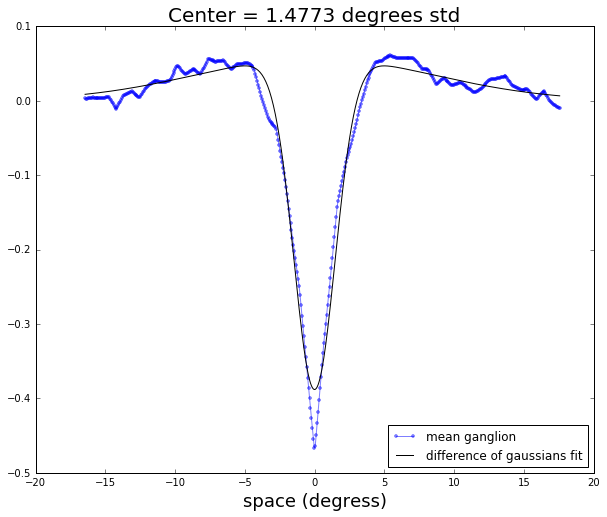

In [13]:
plot(valid_space, mean_ganglion, 'b.-', alpha=0.5, label='mean ganglion')
plot(valid_space, difference, 'k', label='difference of gaussians fit')
plt.legend(loc='lower right')
plt.xlabel('space (degress)', fontsize=18)
plt.title('Center = %0.4f degrees std' %(popt[0]), fontsize=20)

# Define pipeline for filters as fn of SNR

## Find ideal filter that maximizes information

In [14]:
def filter_model(horz_weight, ama_weight, center_weight, surround_weight, center_width=1.751050):
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:int((n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:int(((n-1)/2) + 1)]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

In [15]:
def info_full_fun(weights, ideal_filter_interp, input_noise, output_noise, center_width=center_width, init_filt_const=0.8):
    horz_weight, ama_weight, center_weight, surround_weight = weights
    
    # get model
    filt_interp = filter_model(horz_weight, ama_weight, center_weight, surround_weight, center_width=center_width)
    
    # constrain variance
    def constrain_filt_var(filt_const):
        output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                              (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                              (output_noise)**2)
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (output_variance - filt_variance)**2
    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    # get info
    infos = info_at_freq(more_signal_freq, more_signal_amp, filt_interp, function_const=filt_const, input_noise=0.12, output_noise=0.35)
    return infos

In [16]:
def surround_analysis(noise, center_width=center_width, frequencies=more_signal_freq, amplitude=more_signal_amp,
                     return_flag='sums'):
    
    input_noise, output_noise = noise
    npoints = 10000
    cutoff = 0.4
    init_model_const = 0.95
    init_a_const = 0.95
    init_h_const = 0.95
    init_ganglion_const = 0.95
    init_center_const = 0.95
    
    signal_interp = interp1d(frequencies, amplitude, kind='slinear')
    
    # Get ideal frequency and filter
    freq_ideal, filt_ideal, _, _ = compare_to_experiment(frequencies, amplitude**2, 
                                                         inputNoise=input_noise, 
                                                         outputNoise=output_noise, 
                                                         verbose=False, returnFlag=True, 
                                                         numPoints=npoints, plotFlag=False)
    
    # make an interpolation of it
    ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='linear', 
                               bounds_error=False, fill_value='extrapolate')
    
    # save variance of this ideal filter
    output_variance = np.sum((amplitude*ideal_filter_interp(frequencies))**2 +
                          (input_noise * ideal_filter_interp(frequencies))**2 +
                          (output_noise)**2)
    
    # get info for ideal filter
    cuminfo_ideal = info_at_freq(frequencies, amplitude, ideal_filter_interp, output_noise=output_noise, input_noise=input_noise)
    
    # fit models; use lower frequency range just for MSE minimization, not for info calculation
    lowerer_freqs = [f for f in frequencies if f < cutoff]
    
    ############ full model ############
    model_freqs, model_fft, horz_weight, ama_weight, center_weight, surround_weight, center_width = fit_ideal(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs),
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
    cuminfo_model = info_full_fun([horz_weight, ama_weight, center_weight, surround_weight], 
                                  ideal_filter_interp, input_noise, output_noise, center_width=center_width)
    
    ############ horizontal model ############
    h_freqs, h_fft, center_weight, surround_weight, center_width = fit_ideal_horz_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
    cuminfo_h = info_full_fun([1.0, 0.0, center_weight, surround_weight],
                              ideal_filter_interp, input_noise, output_noise, center_width=center_width)

    
    ############ amacrine model ############
    a_freqs, a_fft, center_weight, surround_weight, center_width = fit_ideal_ama_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
    cuminfo_a = info_full_fun([0.0, 1.0, center_weight, surround_weight],
                              ideal_filter_interp, input_noise, output_noise, center_width=center_width)
    
    ############ ganglion cell ############
    rf_f_two_sided = abs(np.fft.fft(mean_ganglion-np.mean(mean_ganglion))) / np.prod(mean_ganglion.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:(int(n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:(int((n-1)/2) + 1)]
    spacing = valid_space[-1] - valid_space[-2]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    ganglion_freqs = rf_freqs_one_sided
    ganglion_amps = rf_f_one_sided
    
    ganglion_interp = interp1d(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

    def constrain_ganglion_var(ganglion_const):
        output_variance = np.sum((amplitude*ideal_filter_interp(frequencies))**2 +
                              (input_noise * ideal_filter_interp(frequencies))**2 +
                              (output_noise)**2)
        ganglion_variance = np.sum((amplitude*ganglion_const*ganglion_interp(frequencies))**2 +
                              (input_noise * ganglion_const * ganglion_interp(frequencies))**2 +
                              (output_noise)**2)

        return (output_variance - ganglion_variance)**2
    
    ganglion_const_opt = scipy.optimize.minimize(constrain_ganglion_var, init_ganglion_const)
    ganglion_const = abs(ganglion_const_opt['x'])
    ganglion_const_opt
    
    cuminfo_ganglion = info_at_freq(frequencies, amplitude, ganglion_interp, function_const=ganglion_const, output_noise=output_noise, input_noise=input_noise)
    
    
    ############ center ############
    center = gaussian(x=valid_space, sigma=center_width, mu=0)
    rf_f_two_sided = abs(np.fft.fft(center)) / np.prod(center.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:(int(n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:(int((n-1)/2) + 1)]
    spacing = valid_space[-1] - valid_space[-2]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    center_freqs = rf_freqs_one_sided
    center_amps = rf_f_one_sided
    
    center_interp = interp1d(center_freqs, center_amps/np.nanmax(center_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

    def constrain_center_var(center_const):
        output_variance = np.sum((amplitude*ideal_filter_interp(frequencies))**2 +
                              (input_noise * ideal_filter_interp(frequencies))**2 +
                              (output_noise)**2)
        center_variance = np.sum((amplitude*center_const*center_interp(frequencies))**2 +
                              (input_noise * center_const * center_interp(frequencies))**2 +
                              (output_noise)**2)

        return (output_variance - center_variance)**2

    center_const_opt = scipy.optimize.minimize(constrain_center_var, init_center_const)
    center_const = abs(center_const_opt['x'])
    center_const_opt

    cuminfo_center = info_at_freq(frequencies, amplitude, center_interp, function_const=center_const, output_noise=output_noise, input_noise=input_noise)
    
    if return_flag == 'sums':
        return [np.sum(cuminfo_ideal), np.sum(cuminfo_ganglion), np.sum(cuminfo_model),
               np.sum(cuminfo_h), np.sum(cuminfo_a), np.sum(cuminfo_center)]
    else:
        return [cuminfo_ideal, cuminfo_ganglion, cuminfo_model,
               cuminfo_h, cuminfo_a, cuminfo_center]

In [17]:
center_width

1.4772965311658066

#### Sanity check

In [18]:
info_ideal, info_ganglion, info_model, info_h, info_a, info_center = surround_analysis([0.12, 0.35], return_flag='sums')

In [19]:
print([info_ideal, info_ganglion, info_model, info_h, info_a, info_center])

[8.6367683626431386, 8.4393380919516137, 8.5647104997911327, 8.1630144600975783, 6.0567479859155844, 4.3254629488459919]


In [20]:
# plt.plot(more_signal_freq, info_ideal, color='#6699ff', linewidth=10, label='ideal')
# plt.plot(more_signal_freq, info_center, 'orange', linewidth=5, label='center')
# plt.plot(more_signal_freq, info_model, color='k', linewidth=5, label='model')
# plt.plot(more_signal_freq, info_a, color='b', linewidth=5, label='amacrine')
# plt.plot(more_signal_freq, info_h, color='g', linewidth=5, label='horizontal')
# plt.plot(more_signal_freq, info_ganglion, 'k--', linewidth=2, markersize=10, label='ganglion data')

# plt.xlabel('Frequency (cycles/deg)', fontsize=18)
# plt.ylabel('Cumulative information (bits)', fontsize=18)
# plt.legend(loc='lower right')
# plt.tick_params(axis='y', direction='out')
# plt.tick_params(axis='x', direction='out')
# plt.xscale('log')
# plt.xlim([1.6*10e-4, 10e-1])
# adjust_spines(plt.gca(), ['left', 'bottom'])
# plt.savefig('Cumulative_info_plot.pdf', fonttype=42)

In [21]:
noises

[(0.05, 0.1), (0.12, 0.35), (0.08, 0.2), (0.2, 0.42)]

In [22]:
def compute_snr(input_noise, output_noise, filt, amplitude=more_signal_amp, mode='total'):
    if mode == 'total':
        signal_var = np.sum((amplitude*filt)**2)
        noise_var = np.sum((input_noise*filt)**2 + (output_noise)**2)
    else:
        signal_var = (amplitude*filt)**2
        noise_var = (input_noise*filt)**2 + (output_noise)**2
    return signal_var/noise_var

In [23]:
npoints = 10000
snrs = []
info_ideals = []
info_ganglions = []
info_models = []
info_hs = []
info_as = []
info_centers = []

input_noises = np.linspace(0.01, 0.2, 20)
output_noises = [0.35]

for in_noise in input_noises:
    for out_noise in output_noises:
        info_ideal, info_ganglion, info_model, info_h, info_a, info_center = surround_analysis([in_noise, out_noise])
        
        # Get ideal frequency and filter
        freq_ideal, filt_ideal, _, _ = compare_to_experiment(more_signal_freq, more_signal_amp**2, 
                                                             inputNoise=in_noise, 
                                                             outputNoise=out_noise, 
                                                             verbose=False, returnFlag=True, 
                                                             numPoints=npoints, plotFlag=False)
        snr = compute_snr(in_noise, out_noise, filt_ideal, amplitude=signal_interp(freq_ideal))

        snrs.append(snr)
        info_ideals.append(info_ideal)
        info_ganglions.append(info_ganglion)
        info_models.append(info_model)
        info_hs.append(info_h)
        info_as.append(info_a)
        info_centers.append(info_center)
        
        

In [24]:
# plt.plot(snrs, info_ideals, color='#6699ff', linewidth=10, label='ideal')
# plt.plot(snrs, info_centers, 'orange', linewidth=5, label='center')
# plt.plot(snrs, info_models, color='k', linewidth=5, label='model')
# plt.plot(snrs, info_as, color='b', linewidth=5, label='amacrine')
# plt.plot(snrs, info_hs, color='g', linewidth=5, label='horizontal')
# plt.plot(snrs, info_ganglions, 'k--', linewidth=2, markersize=10, label='ganglion data')

# plt.xlabel('SNRs', fontsize=18)
# plt.ylabel('Cumulative information (bits)', fontsize=18)
# plt.legend(loc='lower right')
# plt.tick_params(axis='y', direction='out')
# plt.tick_params(axis='x', direction='out')
# # plt.xscale('log')
# # plt.xlim([1.6*10e-4, 10e-1])
# adjust_spines(plt.gca(), ['left', 'bottom'])
# # plt.savefig('Cumulative_info_plot.pdf', fonttype=42)

In [25]:
snrs

[0.03136039902371849,
 0.022886116617623551,
 0.019578467572690543,
 0.017886654239427102,
 0.016936395383298265,
 0.016398486207712858,
 0.016119482430168308,
 0.016017435085329369,
 0.016044119051846342,
 0.016169308486547025,
 0.016372785953024556,
 0.016640498784338934,
 0.016962295586146228,
 0.017330551183383096,
 0.01773931086416991,
 0.018183788098630166,
 0.018660104455819025,
 0.019164929413924371,
 0.019695343983871603,
 0.020248855261971718]

In [26]:
# plt.plot(snrs, info_ideals, '.')
# plt.plot(snrs, info_models)

In [27]:
len(info_models[0])

TypeError: object of type 'numpy.float64' has no len()